In [36]:
# Cell 1 — Environment Setup & Cleanup Old W&B Runs

!pip install torch torchvision timm wandb scikit-learn matplotlib pandas

import os, shutil, random
import numpy as np
import torch

def safe_rmtree(path):
    if os.path.isdir(path):
        shutil.rmtree(path, ignore_errors=True)
        print(f"Removed old directory: {path}")

# Remove any old W&B dirs
for d in ["wandb", "wandb_folder2", "wandb_folder3"]:
    safe_rmtree(d)

# Reproducibility
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
print(" Seed set to", seed)

#Point the dataset at the correct folder
base_dir = "fitzpatrick17k_dataset"
if not os.path.isdir(base_dir):
    raise FileNotFoundError(f"Dataset directory not found: {base_dir}")
print(" Dataset directory:", base_dir)


✔ Seed set to 1234
✔ Dataset directory: fitzpatrick17k_dataset


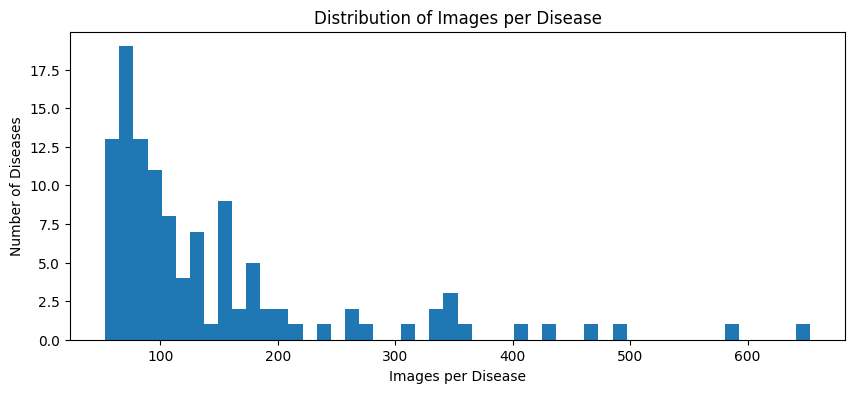

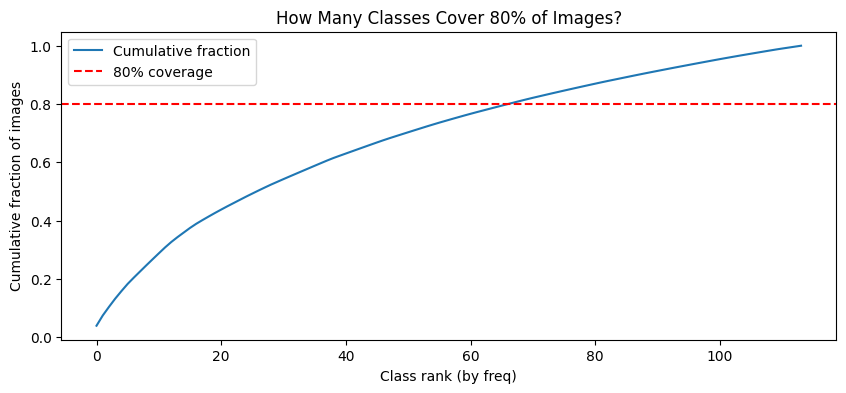

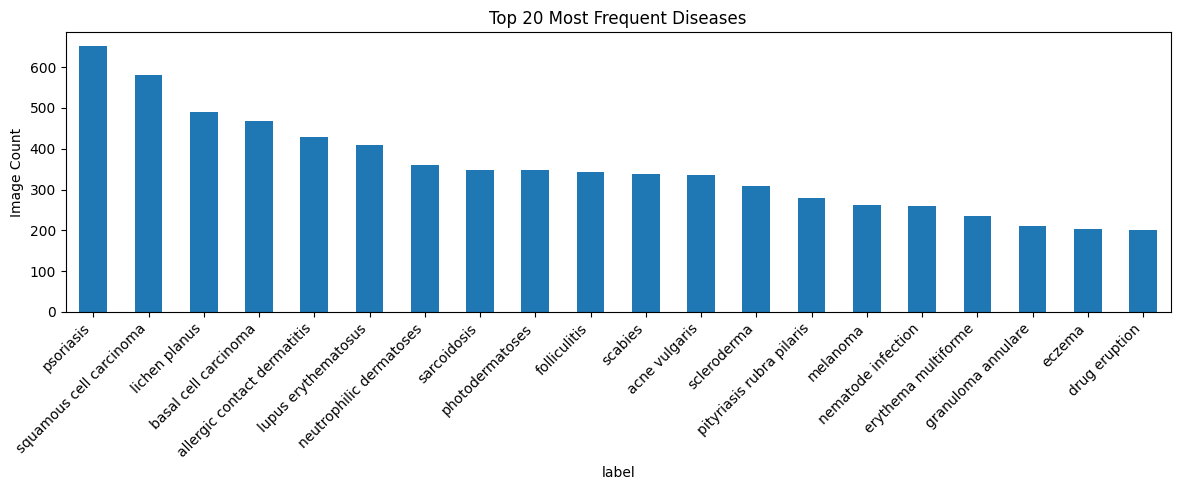

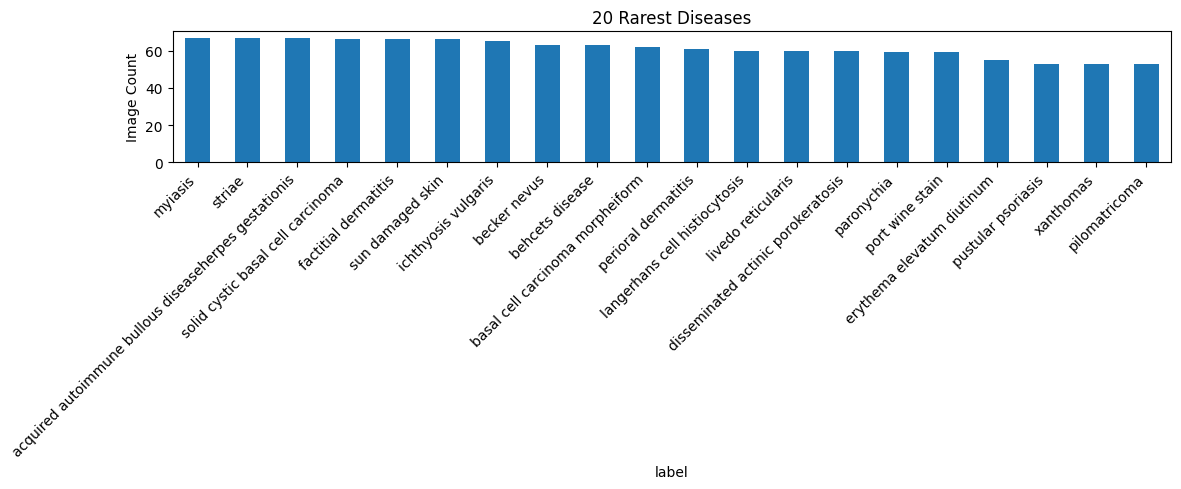

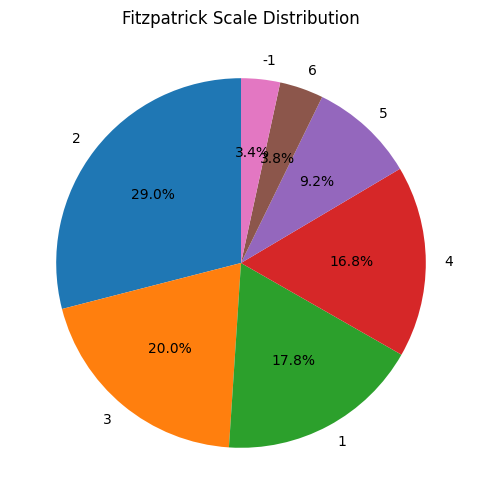

In [37]:
# Cell 2 — Metadata Exploration & Plots (expanded)

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("fitzpatrick17k.csv")
counts = df['label'].value_counts()

# 1) Histogram of images per disease
plt.figure(figsize=(10,4))
plt.hist(counts, bins=50)
plt.title("Distribution of Images per Disease")
plt.xlabel("Images per Disease")
plt.ylabel("Number of Diseases")
plt.show()

# 2) Cumulative coverage by top-k classes
cum = counts.sort_values(ascending=False).cumsum() / counts.sum()
plt.figure(figsize=(10,4))
plt.plot(cum.values, label="Cumulative fraction")
plt.axhline(0.80, color='red', linestyle='--', label="80% coverage")
plt.title("How Many Classes Cover 80% of Images?")
plt.xlabel("Class rank (by freq)")
plt.ylabel("Cumulative fraction of images")
plt.legend()
plt.show()

# 3) Top 20 most common diseases
plt.figure(figsize=(12,5))
counts.head(20).plot(kind='bar')
plt.title("Top 20 Most Frequent Diseases")
plt.ylabel("Image Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4) 20 Rarest diseases
plt.figure(figsize=(12,5))
counts.tail(20).plot(kind='bar')
plt.title("20 Rarest Diseases")
plt.ylabel("Image Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5) Fitzpatrick scale breakdown (if available)
if 'fitzpatrick_scale' in df.columns:
    plt.figure(figsize=(6,6))
    df['fitzpatrick_scale'].value_counts().plot(
        kind='pie', autopct='%1.1f%%', startangle=90
    )
    plt.title("Fitzpatrick Scale Distribution")
    plt.ylabel("")
    plt.show()



In [38]:
# Cell 3 — Define Mild Augmentations & Transforms

import torchvision.transforms as T

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# Mild training augmentations
train_transforms = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(0.1, 0.1, 0.1, 0.05),
    T.ToTensor(),
    T.Normalize(mean, std),
])

# Standard test transforms
test_transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std),
])

print("Train transforms:", train_transforms)
print("Test transforms: ", test_transforms)


Train transforms: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.05, 0.05))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test transforms:  Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [39]:
# Cell 4 — Filter to ≥49-shot Classes & Stratified Split (self-contained)

import os
import shutil
import pandas as pd
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

# 0) Remove stray “.ipynb_checkpoints” folders
for root, dirs, _ in os.walk(base_dir):
    if ".ipynb_checkpoints" in dirs:
        shutil.rmtree(os.path.join(root, ".ipynb_checkpoints"))

# 1) Read metadata and compute per‐class counts
df         = pd.read_csv("fitzpatrick17k.csv")
counts     = df["label"].value_counts()               
threshold  = 49
keep_classes = counts[counts >= threshold].index.tolist()
print(f"Keeping {len(keep_classes)} classes (≥{threshold} samples)")

# 2) Build ImageFolder & mapping
full_ds      = ImageFolder(root=base_dir, transform=None)
class_to_idx = full_ds.class_to_idx

# 3) Collect sample indices for kept classes
filtered = [
    (i, lbl)
    for i, (_, lbl) in enumerate(full_ds.samples)
    if full_ds.classes[lbl] in keep_classes
]
indices, labels = zip(*filtered)

# 4) Stratified 80/20 split
train_idx, test_idx = train_test_split(
    list(indices),
    test_size=0.2,
    stratify=labels,
    random_state=seed
)
print(f"→ train: {len(train_idx)} samples, test: {len(test_idx)} samples")


Keeping 114 classes (≥49 samples)
→ train: 4459 samples, test: 1115 samples


In [54]:

num_classes = len(keep_classes)
print("Num classes =", num_classes)


Num classes = 114


In [55]:
# Cell 5 — Build Subsets, Weighted Sampler & DataLoaders

from torch.utils.data import Subset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from collections import Counter

batch_size = 16

# 1) Create train & test Subsets with your mild transforms
train_ds = Subset(
    ImageFolder(root=base_dir, transform=train_transforms),
    train_idx
)
test_ds = Subset(
    ImageFolder(root=base_dir, transform=test_transforms),
    test_idx
)

# 2) Compute class frequencies on the training split
train_labels   = [full_ds.samples[i][1] for i in train_idx]
counts         = Counter(train_labels)
class_weights  = {c: 1.0/count for c, count in counts.items()}

# 3) Build a per-sample weight list & sampler
sample_weights = [class_weights[full_ds.samples[i][1]] for i in train_idx]
sampler        = WeightedRandomSampler(sample_weights,
                                       num_samples=len(sample_weights),
                                       replacement=True)

# 4) DataLoaders
train_loader = DataLoader(
    train_ds, batch_size=batch_size, sampler=sampler,
    num_workers=4, pin_memory=True
)
test_loader  = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True
)

print(f" DataLoaders ready – train {len(train_ds)} samples, test {len(test_ds)} samples")


✔️ DataLoaders ready – train 4459 samples, test 1115 samples


/home/kerem.farzaliyev001/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [56]:
# Cell 6 — Model Helper & Device

import torch
import torch.nn as nn
import torchvision.models as models
import timm

# 1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Model factory: returns a model on `device`, with a dropout‐augmented head
def get_model(name, num_classes, pretrained=True, dropout=0.3):
    if name == "resnet50":
        m = models.resnet50(pretrained=pretrained)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_f, num_classes))
    elif name == "resnet101":
        m = models.resnet101(pretrained=pretrained)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_f, num_classes))
    elif name == "densenet201":
        m = models.densenet201(pretrained=pretrained)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_f, num_classes))
    elif name == "efficientnet_b0":
        m = models.efficientnet_b0(pretrained=pretrained)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_f, num_classes))
    elif name == "convnext_base":
        m = timm.create_model("convnext_base", pretrained=pretrained, num_classes=num_classes)
    elif name == "mobilenetv3_large":
        m = models.mobilenet_v3_large(pretrained=pretrained)
        in_f = m.classifier[-1].in_features
        m.classifier = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_f, num_classes))
    elif name == "deit_tiny_distilled":
        m = timm.create_model("deit_tiny_distilled_patch16_224", pretrained=pretrained, num_classes=num_classes)
    elif name == "vit_base_patch16_224":
        m = timm.create_model("vit_base_patch16_224", pretrained=pretrained, num_classes=num_classes)
    elif name == "swin_base_patch4_window7_224":
        m = timm.create_model("swin_base_patch4_window7_224", pretrained=pretrained, num_classes=num_classes)
    elif name == "efficientnetv2_m":
        # no official pretrained weights; use random init
        m = timm.create_model("efficientnetv2_m", pretrained=False, num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(device)

print("✔ Model helper ready on", device)


✔ Model helper ready on cuda


In [60]:
# Cell 7 — Loss, Optimizer & Scheduler
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# standard cross‐entropy
criterion = nn.CrossEntropyLoss()

def make_optimizer_and_scheduler(model, lr, weight_decay, epochs):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # cosine decay from lr → 0 over “epochs” steps
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    return optimizer, scheduler

print(" make_optimizer_and_scheduler ready)



✔ make_optimizer_and_scheduler ready (you’ll pass cfg.lr, cfg.weight_decay, cfg.epochs)


In [61]:
# Cell 8 — W&B Init & Hookup

import wandb

# 1) Login & init
wandb.login()
run = wandb.init(
    project="dermatology-ai-v10",
    name="baseline_bs16_seed1234",
    config={
        "batch_size": 16,
        "seed": 1234,
        "threshold": 49,
        "epochs": 30,
        "lr": 1e-4,
        "weight_decay": 1e-3,
        "patience": 5,
        "augmentation": "mild",
    },
    reinit=True
)

# 2) Pull into cfg and copy to a plain dict
cfg         = wandb.config
base_config = dict(cfg)   


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [63]:
# Cell 9 — Train ResNet-50 (30 epochs, patience=5)
import wandb, torch
import torch.nn as nn

run = wandb.init(
    project="dermatology-ai-v10",
    name="resnet50_bs16_seed1234",
    config={**base_config, "model": "resnet50"},
    reinit=True
)
cfg = wandb.config

# 1) build model + loss
model     = get_model("resnet50", num_classes, pretrained=True)
criterion = nn.CrossEntropyLoss()

# 2) optimizer + scheduler 
optimizer, scheduler = make_optimizer_and_scheduler(
    model,
    cfg.lr,
    cfg.weight_decay,
    cfg.epochs
)

best_val_acc = 0.0
no_improve   = 0

for epoch in range(cfg.epochs):
    # — Train —
    model.train()
    running_loss = running_correct = total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out    = model(x)
        loss   = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * x.size(0)
        running_correct += (out.argmax(1) == y).sum().item()
        total           += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total

    # — Validate —
    model.eval()
    v_loss = v_corr = v_tot = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y   = x.to(device), y.to(device)
            out    = model(x)
            loss   = criterion(out, y)
            v_loss += loss.item() * x.size(0)
            v_corr += (out.argmax(1) == y).sum().item()
            v_tot  += x.size(0)

    val_loss = v_loss / v_tot
    val_acc  = v_corr / v_tot

    # step the lr‐scheduler
    scheduler.step()

    # log everything
    wandb.log({
      "epoch":    epoch+1,
      "train_loss": train_loss, "train_acc": train_acc,
      "val_loss":   val_loss,   "val_acc":   val_acc,
      "lr":         scheduler.get_last_lr()[0]
    })

    print(f"[ResNet50] Epoch {epoch+1}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    # early stop + save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve   = 0
        torch.save(model.state_dict(), "best_resnet50.pt")
    else:
        no_improve += 1
        if no_improve >= cfg.patience:
            print(f"→ Early stopping at epoch {epoch+1}")
            break

run.finish()


[ResNet50] Epoch 1: train_acc=0.2530, val_acc=0.3103
[ResNet50] Epoch 2: train_acc=0.4153, val_acc=0.3623
[ResNet50] Epoch 3: train_acc=0.5089, val_acc=0.4197
[ResNet50] Epoch 4: train_acc=0.5508, val_acc=0.4341
[ResNet50] Epoch 5: train_acc=0.5934, val_acc=0.4673
[ResNet50] Epoch 6: train_acc=0.6279, val_acc=0.4978
[ResNet50] Epoch 7: train_acc=0.6584, val_acc=0.4825
[ResNet50] Epoch 8: train_acc=0.6878, val_acc=0.5175
[ResNet50] Epoch 9: train_acc=0.7073, val_acc=0.5274
[ResNet50] Epoch 10: train_acc=0.7168, val_acc=0.5318
[ResNet50] Epoch 11: train_acc=0.7434, val_acc=0.5471
[ResNet50] Epoch 12: train_acc=0.7522, val_acc=0.5614
[ResNet50] Epoch 13: train_acc=0.7766, val_acc=0.5605
[ResNet50] Epoch 14: train_acc=0.7733, val_acc=0.5605
[ResNet50] Epoch 15: train_acc=0.8017, val_acc=0.5892
[ResNet50] Epoch 16: train_acc=0.8132, val_acc=0.5865
[ResNet50] Epoch 17: train_acc=0.8278, val_acc=0.5857
[ResNet50] Epoch 18: train_acc=0.8322, val_acc=0.5910
[ResNet50] Epoch 19: train_acc=0.8531

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train_acc,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████████
train_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█▇████████
val_loss,█▇▅▅▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch,30
lr,0
train_acc,0.89886
train_loss,0.35797
val_acc,0.63318


In [65]:
# Cell 10 — Train DenseNet-201 (30 epochs, patience=5)

import wandb, torch
import torch.nn as nn

run = wandb.init(
    project="dermatology-ai-v10",
    name="densenet201_bs16_seed1234",
    config={**base_config, "model": "densenet201"},
    reinit=True
)
cfg = wandb.config

model     = get_model("densenet201", num_classes, pretrained=True)
criterion = nn.CrossEntropyLoss()

# 2) optimizer + scheduler 
optimizer, scheduler = make_optimizer_and_scheduler(
    model,
    cfg.lr,
    cfg.weight_decay,
    cfg.epochs
)

best_val_acc = 0.0
no_improve   = 0

for epoch in range(cfg.epochs):
    # — Train —
    model.train()
    running_loss = running_correct = total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out    = model(x)
        loss   = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * x.size(0)
        running_correct += (out.argmax(1) == y).sum().item()
        total           += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total


    # — Validate —
    model.eval()
    v_loss = v_corr = v_tot = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y   = x.to(device), y.to(device)
            out    = model(x)
            loss   = criterion(out, y)
            v_loss += loss.item() * x.size(0)
            v_corr += (out.argmax(1) == y).sum().item()
            v_tot  += x.size(0)

    val_loss = v_loss / v_tot
    val_acc  = v_corr / v_tot

    # step the lr‐scheduler
    scheduler.step()

    # log everything
    wandb.log({
      "epoch":    epoch+1,
      "train_loss": train_loss, "train_acc": train_acc,
      "val_loss":   val_loss,   "val_acc":   val_acc,
      "lr":         scheduler.get_last_lr()[0]
    })

    print(f"[DenseNet201] Epoch {epoch+1}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve   = 0
        torch.save(model.state_dict(), "best_densenet201.pt")
    else:
        no_improve += 1
        if no_improve >= cfg.patience:
            print(f"→ Early stopping at epoch {epoch+1}")
            break

run.finish()


/home/kerem.farzaliyev001/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[DenseNet201] Epoch 1: train_acc=0.2635, val_acc=0.3130
[DenseNet201] Epoch 2: train_acc=0.4431, val_acc=0.4520
[DenseNet201] Epoch 3: train_acc=0.5490, val_acc=0.4628
[DenseNet201] Epoch 4: train_acc=0.6111, val_acc=0.5022
[DenseNet201] Epoch 5: train_acc=0.6508, val_acc=0.5399
[DenseNet201] Epoch 6: train_acc=0.6975, val_acc=0.5525
[DenseNet201] Epoch 7: train_acc=0.7208, val_acc=0.5686
[DenseNet201] Epoch 8: train_acc=0.7591, val_acc=0.5749
[DenseNet201] Epoch 9: train_acc=0.7737, val_acc=0.5955
[DenseNet201] Epoch 10: train_acc=0.7811, val_acc=0.6063
[DenseNet201] Epoch 11: train_acc=0.8004, val_acc=0.6135
[DenseNet201] Epoch 12: train_acc=0.8215, val_acc=0.5991
[DenseNet201] Epoch 13: train_acc=0.8224, val_acc=0.6099
[DenseNet201] Epoch 14: train_acc=0.8455, val_acc=0.6332
[DenseNet201] Epoch 15: train_acc=0.8677, val_acc=0.6484
[DenseNet201] Epoch 16: train_acc=0.8661, val_acc=0.6350
[DenseNet201] Epoch 17: train_acc=0.8773, val_acc=0.6323
[DenseNet201] Epoch 18: train_acc=0.8802

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train_acc,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇██████████
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,30
lr,0
train_acc,0.91994
train_loss,0.29249
val_acc,0.67265


In [66]:
# Cell 13 — Train ConvNeXt-Base (30 epochs, patience=5)

import wandb, torch
import torch.nn as nn

run = wandb.init(
    project="dermatology-ai-v10",
    name="convnext_base_bs16_seed1234",
    config={**base_config, "model": "convnext_base"},
    reinit=True
)
cfg = wandb.config

model     = get_model("convnext_base", num_classes, pretrained=True)
criterion = nn.CrossEntropyLoss()

# 2) optimizer + scheduler
optimizer, scheduler = make_optimizer_and_scheduler(
    model,
    cfg.lr,
    cfg.weight_decay,
    cfg.epochs
)

best_val_acc = 0.0
no_improve   = 0

for epoch in range(cfg.epochs):
    # — Train —
    model.train()
    running_loss = running_correct = total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out    = model(x)
        loss   = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * x.size(0)
        running_correct += (out.argmax(1) == y).sum().item()
        total           += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total


    # — Validate —
    model.eval()
    v_loss = v_corr = v_tot = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y   = x.to(device), y.to(device)
            out    = model(x)
            loss   = criterion(out, y)
            v_loss += loss.item() * x.size(0)
            v_corr += (out.argmax(1) == y).sum().item()
            v_tot  += x.size(0)

    val_loss = v_loss / v_tot
    val_acc  = v_corr / v_tot

    # step the lr‐scheduler
    scheduler.step()

    # log everything
    wandb.log({
      "epoch":    epoch+1,
      "train_loss": train_loss, "train_acc": train_acc,
      "val_loss":   val_loss,   "val_acc":   val_acc,
      "lr":         scheduler.get_last_lr()[0]
    })

    print(f"[ConvNeXt] Epoch {epoch+1}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve   = 0
        torch.save(model.state_dict(), "best_convnext_base.pt")
    else:
        no_improve += 1
        if no_improve >= cfg.patience:
            print(f"→ Early stopping at epoch {epoch+1}")
            break

run.finish()


[ConvNeXt] Epoch 1: train_acc=0.3873, val_acc=0.4529
[ConvNeXt] Epoch 2: train_acc=0.6425, val_acc=0.5489
[ConvNeXt] Epoch 3: train_acc=0.7428, val_acc=0.5964
[ConvNeXt] Epoch 4: train_acc=0.8188, val_acc=0.6413
[ConvNeXt] Epoch 5: train_acc=0.8562, val_acc=0.6520
[ConvNeXt] Epoch 6: train_acc=0.8690, val_acc=0.6610
[ConvNeXt] Epoch 7: train_acc=0.8872, val_acc=0.6601
[ConvNeXt] Epoch 8: train_acc=0.9181, val_acc=0.6969
[ConvNeXt] Epoch 9: train_acc=0.9148, val_acc=0.6807
[ConvNeXt] Epoch 10: train_acc=0.9237, val_acc=0.6816
[ConvNeXt] Epoch 11: train_acc=0.9341, val_acc=0.7022
[ConvNeXt] Epoch 12: train_acc=0.9394, val_acc=0.6924
[ConvNeXt] Epoch 13: train_acc=0.9491, val_acc=0.6969
[ConvNeXt] Epoch 14: train_acc=0.9536, val_acc=0.7031
[ConvNeXt] Epoch 15: train_acc=0.9527, val_acc=0.7013
[ConvNeXt] Epoch 16: train_acc=0.9646, val_acc=0.7031
[ConvNeXt] Epoch 17: train_acc=0.9547, val_acc=0.7031
[ConvNeXt] Epoch 18: train_acc=0.9610, val_acc=0.7067
[ConvNeXt] Epoch 19: train_acc=0.9628

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
lr,█████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
train_acc,▁▄▅▆▇▇▇▇▇▇▇████████████████
train_loss,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
epoch,27
lr,0.0
train_acc,0.97937
train_loss,0.06681
val_acc,0.73184


In [68]:
# Cell 16 — Train DeiT-Tiny-Distilled (30 epochs, patience=5)

import wandb, torch
import torch.nn as nn

run = wandb.init(
    project="dermatology-ai-v10",
    name="deit_tiny_distilled_bs16_seed1234",
    config={**base_config, "model": "deit_tiny_distilled"},
    reinit=True
)
cfg = wandb.config

model     = get_model("deit_tiny_distilled", num_classes, pretrained=True)
criterion = nn.CrossEntropyLoss()

# 2) optimizer + scheduler 
optimizer, scheduler = make_optimizer_and_scheduler(
    model,
    cfg.lr,
    cfg.weight_decay,
    cfg.epochs
)

best_val_acc = 0.0
no_improve   = 0

for epoch in range(cfg.epochs):
    # — Train —
    model.train()
    running_loss = running_correct = total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out    = model(x)
        loss   = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * x.size(0)
        running_correct += (out.argmax(1) == y).sum().item()
        total           += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total


    # — Validate —
    model.eval()
    v_loss = v_corr = v_tot = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y   = x.to(device), y.to(device)
            out    = model(x)
            loss   = criterion(out, y)
            v_loss += loss.item() * x.size(0)
            v_corr += (out.argmax(1) == y).sum().item()
            v_tot  += x.size(0)

    val_loss = v_loss / v_tot
    val_acc  = v_corr / v_tot

    # step the lr‐scheduler
    scheduler.step()

    # log everything
    wandb.log({
      "epoch":    epoch+1,
      "train_loss": train_loss, "train_acc": train_acc,
      "val_loss":   val_loss,   "val_acc":   val_acc,
      "lr":         scheduler.get_last_lr()[0]
    })

    print(f"[DeiT-Tiny] Epoch {epoch+1}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve   = 0
        torch.save(model.state_dict(), "best_deit_tiny_distilled.pt")
    else:
        no_improve += 1
        if no_improve >= cfg.patience:
            print(f"→ Early stopping at epoch {epoch+1}")
            break

run.finish()


[DeiT-Tiny] Epoch 1: train_acc=0.2196, val_acc=0.2996
[DeiT-Tiny] Epoch 2: train_acc=0.4445, val_acc=0.3623
[DeiT-Tiny] Epoch 3: train_acc=0.5468, val_acc=0.4000
[DeiT-Tiny] Epoch 4: train_acc=0.6210, val_acc=0.4628
[DeiT-Tiny] Epoch 5: train_acc=0.6661, val_acc=0.5067
[DeiT-Tiny] Epoch 6: train_acc=0.7017, val_acc=0.5085
[DeiT-Tiny] Epoch 7: train_acc=0.7423, val_acc=0.5202
[DeiT-Tiny] Epoch 8: train_acc=0.7609, val_acc=0.5507
[DeiT-Tiny] Epoch 9: train_acc=0.7941, val_acc=0.5821
[DeiT-Tiny] Epoch 10: train_acc=0.7986, val_acc=0.5596
[DeiT-Tiny] Epoch 11: train_acc=0.8302, val_acc=0.5704
[DeiT-Tiny] Epoch 12: train_acc=0.8419, val_acc=0.5740
[DeiT-Tiny] Epoch 13: train_acc=0.8589, val_acc=0.6018
[DeiT-Tiny] Epoch 14: train_acc=0.8675, val_acc=0.5892
[DeiT-Tiny] Epoch 15: train_acc=0.8834, val_acc=0.5695
[DeiT-Tiny] Epoch 16: train_acc=0.8915, val_acc=0.6152
[DeiT-Tiny] Epoch 17: train_acc=0.9081, val_acc=0.6126
[DeiT-Tiny] Epoch 18: train_acc=0.9069, val_acc=0.6287
[DeiT-Tiny] Epoch 1

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train_acc,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇██████████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇████████
val_loss,█▆▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,30
lr,0
train_acc,0.95201
train_loss,0.17399
val_acc,0.67444


In [70]:
# Cell 17 — Train Swin-Base (30 epochs, patience=5)

import wandb, torch
import torch.nn as nn

run = wandb.init(
    project="dermatology-ai-v10",
    name="swin_base_bs16_seed1234",
    config={**base_config, "model": "swin_base_patch4_window7_224"},
    reinit=True
)
cfg = wandb.config

model     = get_model("swin_base_patch4_window7_224", num_classes, pretrained=True)
criterion = nn.CrossEntropyLoss()
# 2) optimizer + scheduler 
optimizer, scheduler = make_optimizer_and_scheduler(
    model,
    cfg.lr,
    cfg.weight_decay,
    cfg.epochs
)

best_val_acc = 0.0
no_improve   = 0

for epoch in range(cfg.epochs):
    # — Train —
    model.train()
    running_loss = running_correct = total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out    = model(x)
        loss   = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * x.size(0)
        running_correct += (out.argmax(1) == y).sum().item()
        total           += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total


    # — Validate —
    model.eval()
    v_loss = v_corr = v_tot = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y   = x.to(device), y.to(device)
            out    = model(x)
            loss   = criterion(out, y)
            v_loss += loss.item() * x.size(0)
            v_corr += (out.argmax(1) == y).sum().item()
            v_tot  += x.size(0)

    val_loss = v_loss / v_tot
    val_acc  = v_corr / v_tot

    # step the lr‐scheduler
    scheduler.step()

    # log everything
    wandb.log({
      "epoch":    epoch+1,
      "train_loss": train_loss, "train_acc": train_acc,
      "val_loss":   val_loss,   "val_acc":   val_acc,
      "lr":         scheduler.get_last_lr()[0]
    })

    print(f"[Swin-Base] Epoch {epoch+1}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve   = 0
        torch.save(model.state_dict(), "best_swin_base.pt")
    else:
        no_improve += 1
        if no_improve >= cfg.patience:
            print(f"→ Early stopping at epoch {epoch+1}")
            break

run.finish()


[Swin-Base] Epoch 1: train_acc=0.3137, val_acc=0.3857
[Swin-Base] Epoch 2: train_acc=0.5723, val_acc=0.5112
[Swin-Base] Epoch 3: train_acc=0.6997, val_acc=0.5211
[Swin-Base] Epoch 4: train_acc=0.7318, val_acc=0.5605
[Swin-Base] Epoch 5: train_acc=0.7587, val_acc=0.5946
[Swin-Base] Epoch 6: train_acc=0.8040, val_acc=0.6251
[Swin-Base] Epoch 7: train_acc=0.8154, val_acc=0.6188
[Swin-Base] Epoch 8: train_acc=0.8430, val_acc=0.6099
[Swin-Base] Epoch 9: train_acc=0.8482, val_acc=0.6439
[Swin-Base] Epoch 10: train_acc=0.8668, val_acc=0.6323
[Swin-Base] Epoch 11: train_acc=0.8935, val_acc=0.6691
[Swin-Base] Epoch 12: train_acc=0.9022, val_acc=0.6807
[Swin-Base] Epoch 13: train_acc=0.9081, val_acc=0.6861
[Swin-Base] Epoch 14: train_acc=0.9181, val_acc=0.6744
[Swin-Base] Epoch 15: train_acc=0.9188, val_acc=0.6673
[Swin-Base] Epoch 16: train_acc=0.9329, val_acc=0.6879
[Swin-Base] Epoch 17: train_acc=0.9372, val_acc=0.7031
[Swin-Base] Epoch 18: train_acc=0.9439, val_acc=0.6924
[Swin-Base] Epoch 1

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇███████████████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▅▆▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,█▅▅▄▃▃▃▃▃▃▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,30
lr,0
train_acc,0.97892
train_loss,0.07518
val_acc,0.73453


In [72]:
# Cell 18 — Load Best Checkpoints into model_dict

import os, torch

# Map each architecture name → checkpoint filename on disk
ckpt_map = {
    "resnet50":            "best_resnet50.pt",
    "densenet201":         "best_densenet201.pt",
    "convnext_base":       "best_convnext_base.pt",
    "deit_tiny_distilled": "best_deit_tiny_distilled.pt",
    "swin_base_patch4_window7_224":           "best_swin_base.pt",
}

model_dict = {}
for name, ckpt in ckpt_map.items():
    # 1) create the same model architecture (no ImageNet init, since we're loading your fine-tuned weights)
    m = get_model(name, num_classes, pretrained=False)
    # 2) load your checkpoint
    path = os.path.join(os.getcwd(), ckpt)
    state = torch.load(path, map_location=device)
    m.load_state_dict(state)
    # 3) switch to eval mode and stash
    m.eval()
    model_dict[name] = m
    print(f" Loaded {ckpt} → {name}")

print("\nAll models ready:", list(model_dict.keys()))


 Loaded best_resnet50.pt → resnet50
 Loaded best_densenet201.pt → densenet201
 Loaded best_convnext_base.pt → convnext_base
 Loaded best_deit_tiny_distilled.pt → deit_tiny_distilled
 Loaded best_swin_base.pt → swin_base_patch4_window7_224

All models ready: ['resnet50', 'densenet201', 'convnext_base', 'deit_tiny_distilled', 'swin_base_patch4_window7_224']


In [73]:
# Cell 19 — Base Ensemble (no TTA)

import torch
import torch.nn.functional as F

all_labels     = torch.cat([y for _, y in test_loader], dim=0).cpu()
ensemble_base  = []

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        # sum softmaxes across models
        m_sum = torch.zeros(x.size(0), num_classes, device=device)
        for m in model_dict.values():
            m_sum += F.softmax(m(x), dim=1)
        # average over models
        m_avg = m_sum / len(model_dict)
        ensemble_base.append(m_avg.cpu())

ensemble_base = torch.cat(ensemble_base, dim=0)
acc_base      = (ensemble_base.argmax(1) == all_labels).float().mean().item()
print(f"Base ensemble (no TTA) val_acc = {acc_base:.4f}")


Base ensemble (no TTA) val_acc = 0.7561


In [74]:
# Cell 20 — Flip TTA on Ensemble

import torch
import torch.nn.functional as F

ensemble_flip = []

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        # two variants: original & horizontally flipped
        variants = [x, torch.flip(x, dims=[3])]
        # sum predictions over variants
        v_sum = torch.zeros(x.size(0), num_classes, device=device)
        for v in variants:
            # ensemble over models for this variant
            m_sum = torch.zeros_like(v_sum)
            for m in model_dict.values():
                m_sum += F.softmax(m(v), dim=1)
            m_avg  = m_sum / len(model_dict)
            v_sum += m_avg
        # average over variants
        v_avg = v_sum / len(variants)
        ensemble_flip.append(v_avg.cpu())

ensemble_flip = torch.cat(ensemble_flip, dim=0)
acc_flip      = (ensemble_flip.argmax(1) == all_labels).float().mean().item()
print(f"Ensemble + flip TTA val_acc = {acc_flip:.4f}")


Ensemble + flip TTA val_acc = 0.7552
